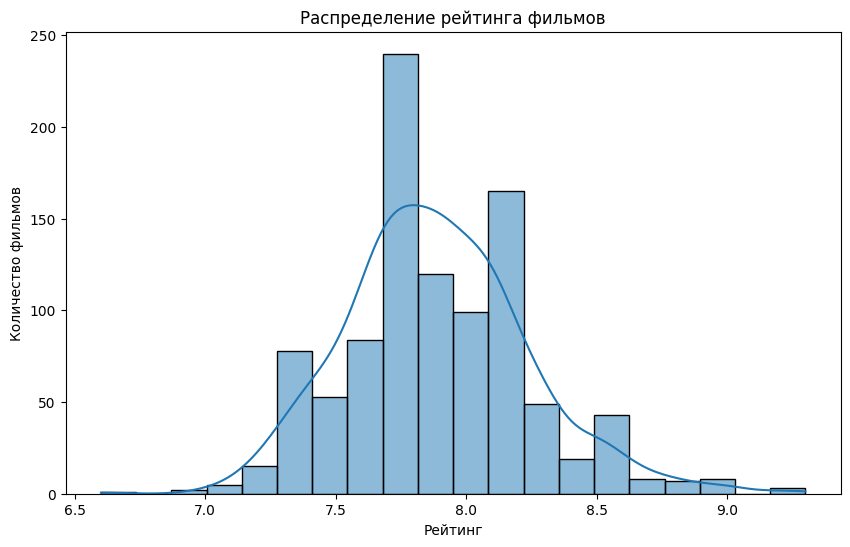

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import pairwise_distances_argmin_min

data = pd.read_csv('imdb_movie_data.csv')

data['Duration'] = data['Duration'].apply(lambda x: int(x[:-1]) * 60 if 'h' in x else int(x[:-1]))

plt.figure(figsize=(10, 6))
sns.histplot(data['Rating'], bins=20, kde=True)
plt.title('Распределение рейтинга фильмов')
plt.xlabel('Рейтинг')
plt.ylabel('Количество фильмов')
plt.show()

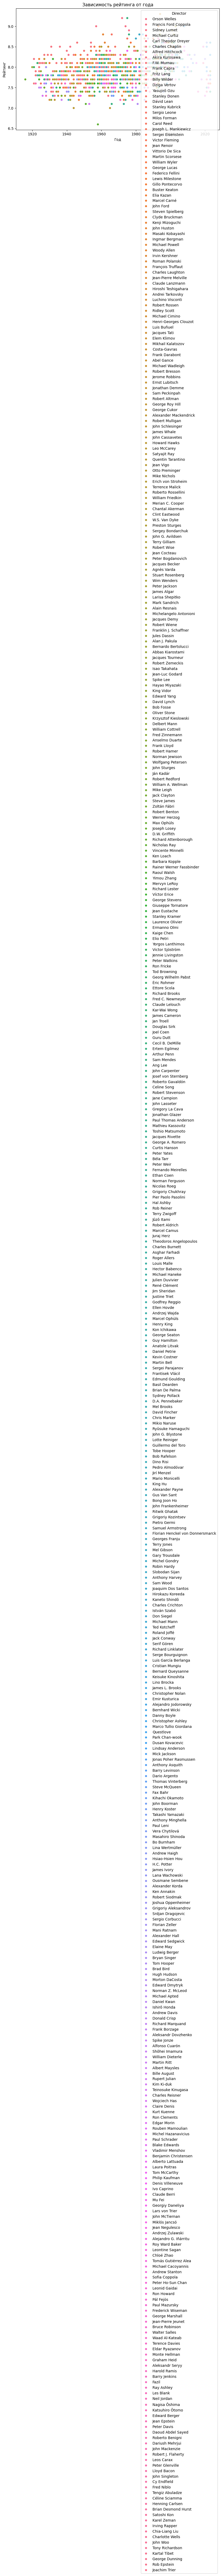

In [9]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Year', y='Rating', hue='Director')
plt.title('Зависимость рейтинга от года')
plt.xlabel('Год')
plt.ylabel('Рейтинг')
plt.show()

In [10]:
X = data[['Year', 'Duration', 'Votes', 'MetaScore']]
y = data['Rating']

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

class SimpleBaseline(BaseEstimator, ClassifierMixin):
    def __init__(self, threshold):
        self.threshold = threshold
    
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.full(len(X), self.threshold)

baseline_model = SimpleBaseline(threshold=np.mean(y_train))
y_train_pred = baseline_model.predict(X_train)
y_val_pred = baseline_model.predict(X_val)
y_test_pred = baseline_model.predict(X_test)

print(f"Baseline Model MSE: {mean_squared_error(y_val, y_val_pred)}")
print(f"Baseline Model R^2 Score: {r2_score(y_val, y_val_pred)}")

Baseline Model MSE: 0.1355705821314324
Baseline Model R^2 Score: -0.00557060563493228


In [11]:
def custom_clustering(X, n_clusters, max_iter=300, tol=1e-4, random_state=42):
    np.random.seed(random_state)
    
    centroids = X[np.random.choice(X.shape[0], n_clusters, replace=False)]
    
    for i in range(max_iter):
        labels = pairwise_distances_argmin_min(X, centroids)[0]
        
        new_centroids = np.array([X[labels == j].mean(axis=0) for j in range(n_clusters)])
        
        if np.all(np.abs(new_centroids - centroids) < tol):
            break
        centroids = new_centroids
    
    return labels, centroids

y_train_cluster_custom, centroids_custom = custom_clustering(X_train_scaled, n_clusters=5)
y_val_cluster_custom, _ = custom_clustering(X_val_scaled, n_clusters=5)
y_test_cluster_custom, _ = custom_clustering(X_test_scaled, n_clusters=5)

print(f"Custom Clustering MSE: {mean_squared_error(y_val, y_val_cluster_custom)}")
print(f"Custom Clustering R^2 Score: {r2_score(y_val, y_val_cluster_custom)}")

Custom Clustering MSE: 37.42813333333333
Custom Clustering R^2 Score: -276.61650139775304


In [12]:
sklearn_kmeans = KMeans(n_clusters=5, random_state=42)
sklearn_kmeans.fit(X_train_scaled)

y_train_sklearn = sklearn_kmeans.labels_
y_val_sklearn = sklearn_kmeans.predict(X_val_scaled)
y_test_sklearn = sklearn_kmeans.predict(X_test_scaled)

print(f"Framework KMeans Clustering MSE: {mean_squared_error(y_val, y_val_sklearn)}")
print(f"Framework KMeans Clustering R^2 Score: {r2_score(y_val, y_val_sklearn)}")

Framework KMeans Clustering MSE: 43.541466666666665
Framework KMeans Clustering R^2 Score: -321.9610607099531


Лучшие гиперпараметры: {'n_clusters': 10, 'random_state': 10}
Optimal KMeans Clustering MSE: 23.353466666666666
Optimal KMeans Clustering R^2 Score: -172.22017247745137


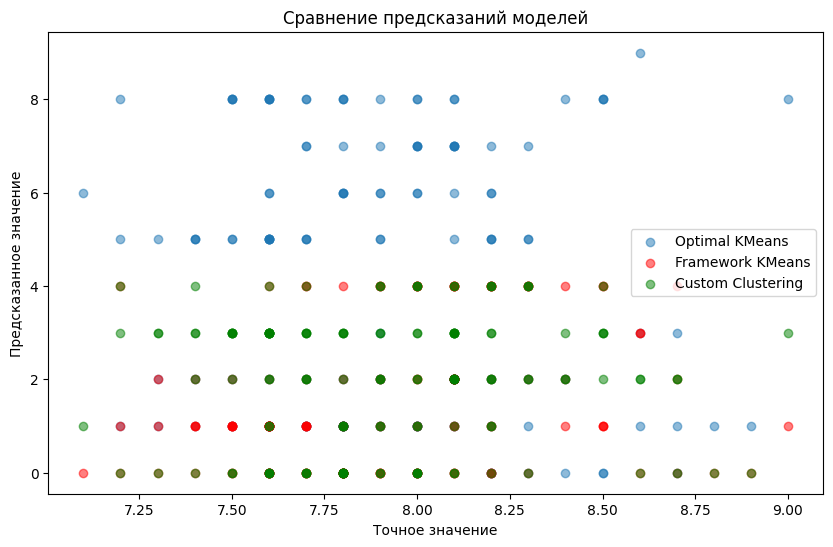

In [13]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_clusters': range(2, 11),
    'random_state': [42, 10]
}

grid_search = GridSearchCV(KMeans(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

print("Лучшие гиперпараметры:", grid_search.best_params_)
best_model = grid_search.best_estimator_

y_val_pred = best_model.predict(X_val_scaled)
y_test_pred = best_model.predict(X_test_scaled)

print(f"Optimal KMeans Clustering MSE: {mean_squared_error(y_val, y_val_pred)}")
print(f"Optimal KMeans Clustering R^2 Score: {r2_score(y_val, y_val_pred)}")

plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_val_pred, alpha=0.5, label='Optimal KMeans')
plt.scatter(y_val, y_val_sklearn, alpha=0.5, color='red', label='Framework KMeans')
plt.scatter(y_val, y_val_cluster_custom, alpha=0.5, color='green', label='Custom Clustering')
plt.title('Сравнение предсказаний моделей')
plt.xlabel('Точное значение')
plt.ylabel('Предсказанное значение')
plt.legend()
plt.show()